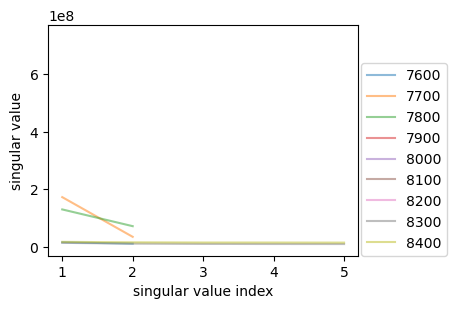

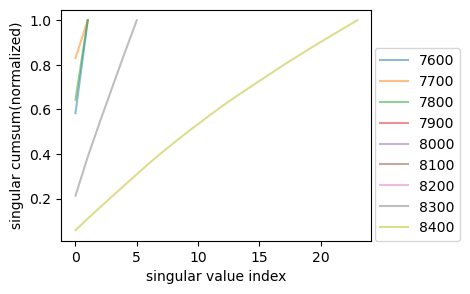

In [1]:
from svd_tool import plot_singular_cum

test_id = 'long_term_forecast_MSE_loss_iTransformer_cov_Couzin_ft-1_sl25_pl25_dm512_nh8_el4_dl1_df512_fc3_flocvali_first_lam0.1_dtTrue_Exp_'
start = 7600
end = 8500
interval = 100
seq_len = 20
gn, gn_std, singular, us, vts, mats, Sigs = plot_singular_cum(test_id, eps=10**7, seed = 1, start=start, end=end, interval=interval, seq_len=seq_len, log_bool=False)


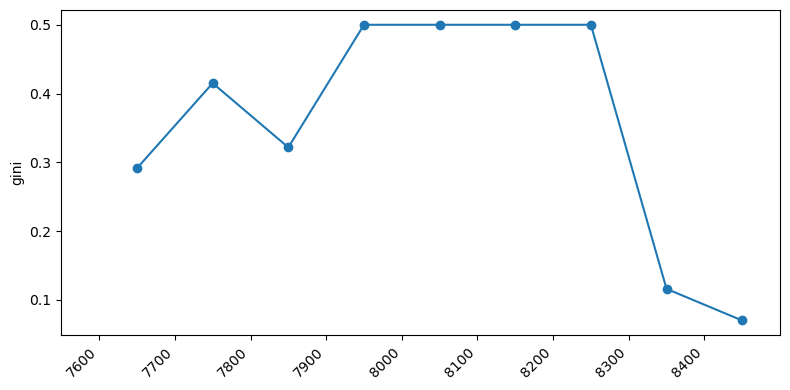

In [2]:
from svd_tool import plot_gini
plot_gini(gn, gn_std)

IndexError: index 1 is out of bounds for axis 2 with size 1

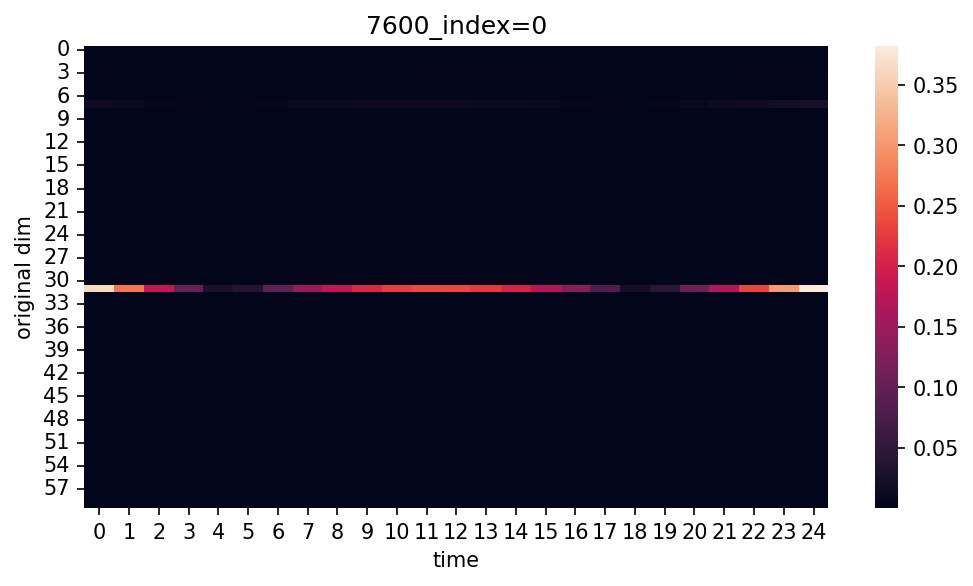

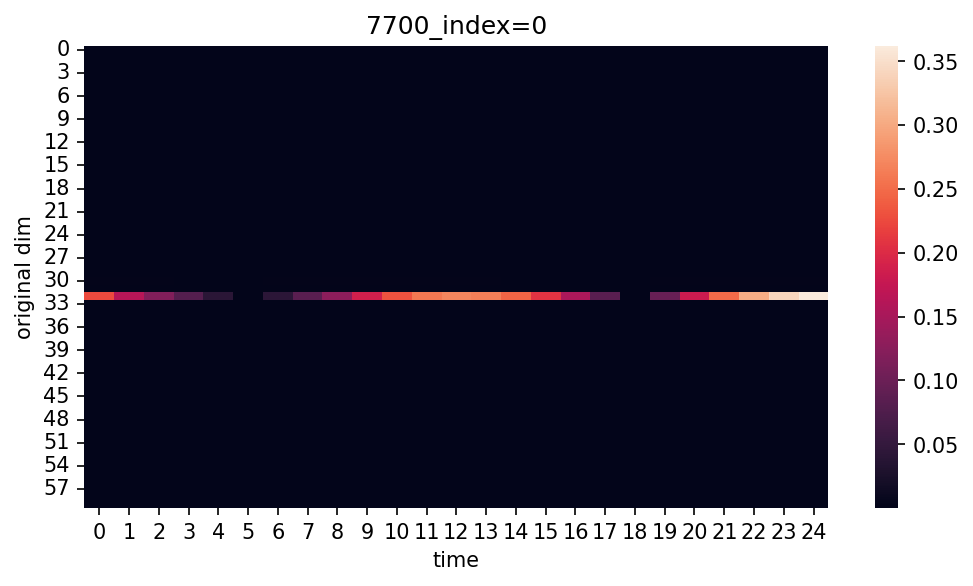

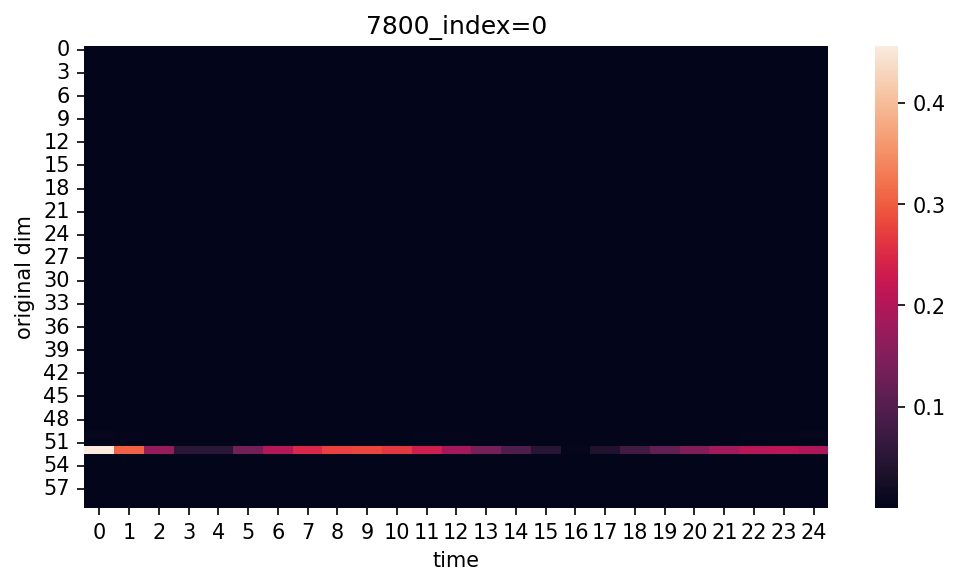

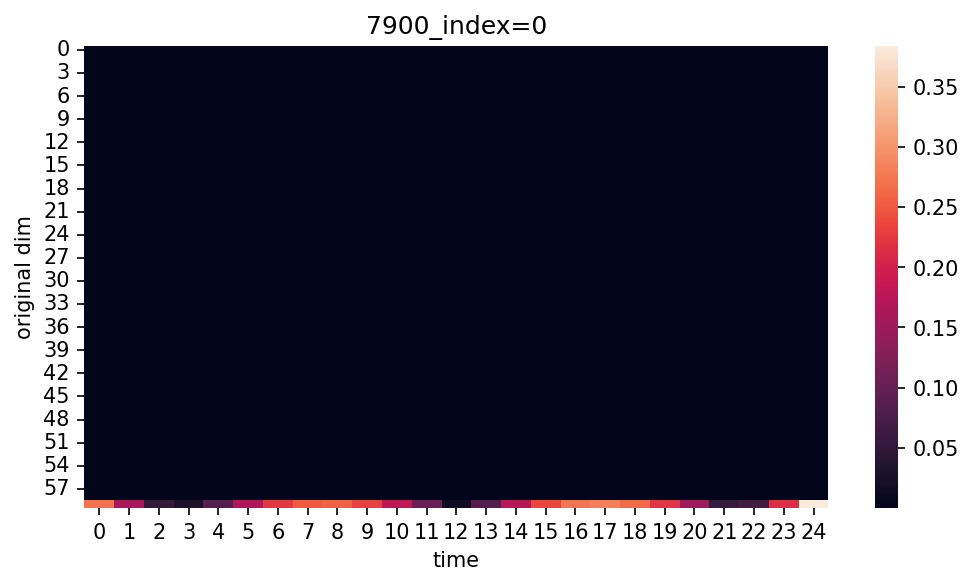

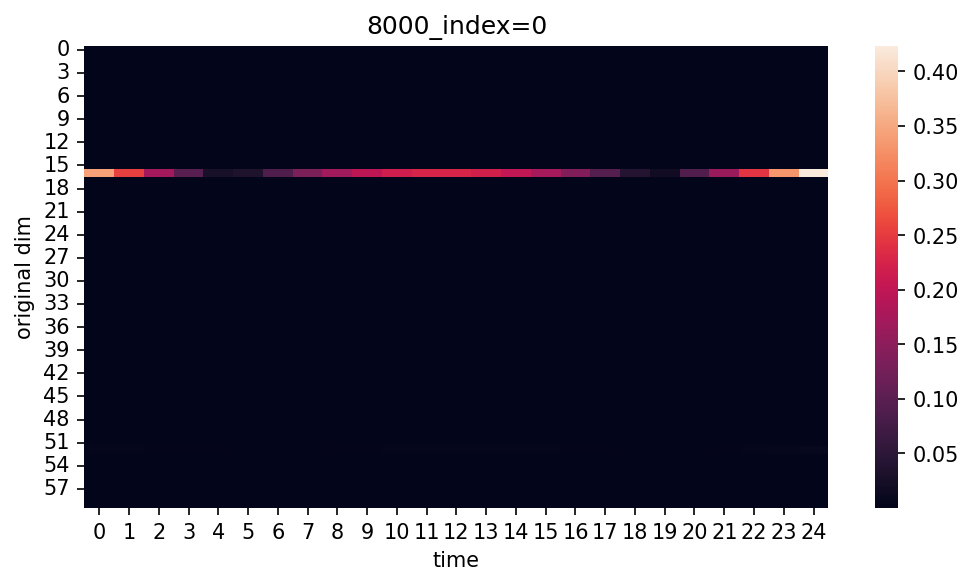

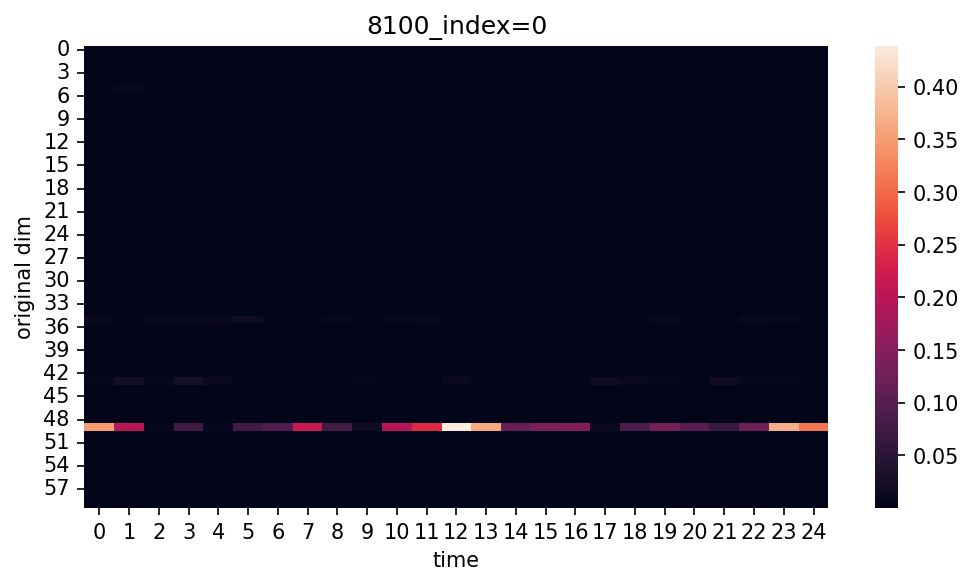

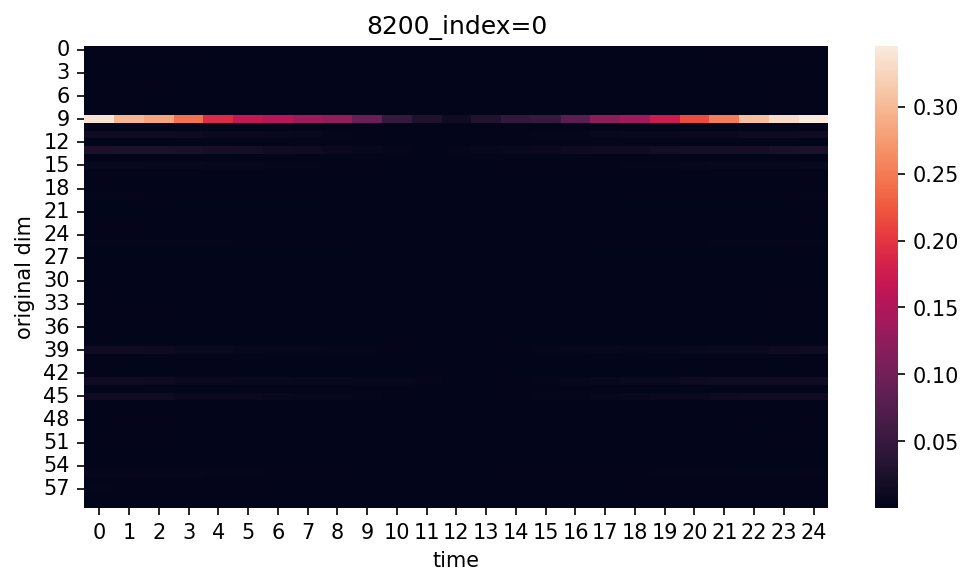

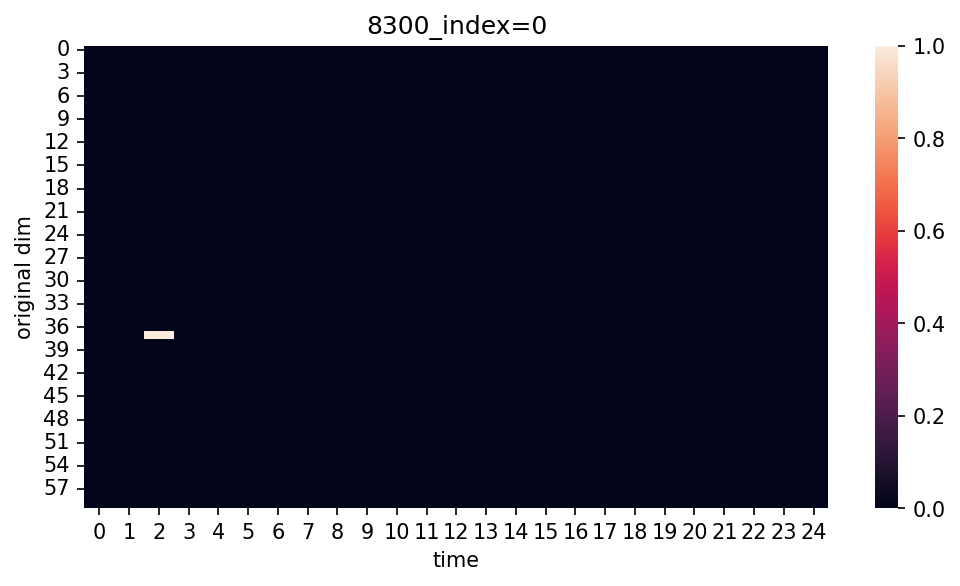

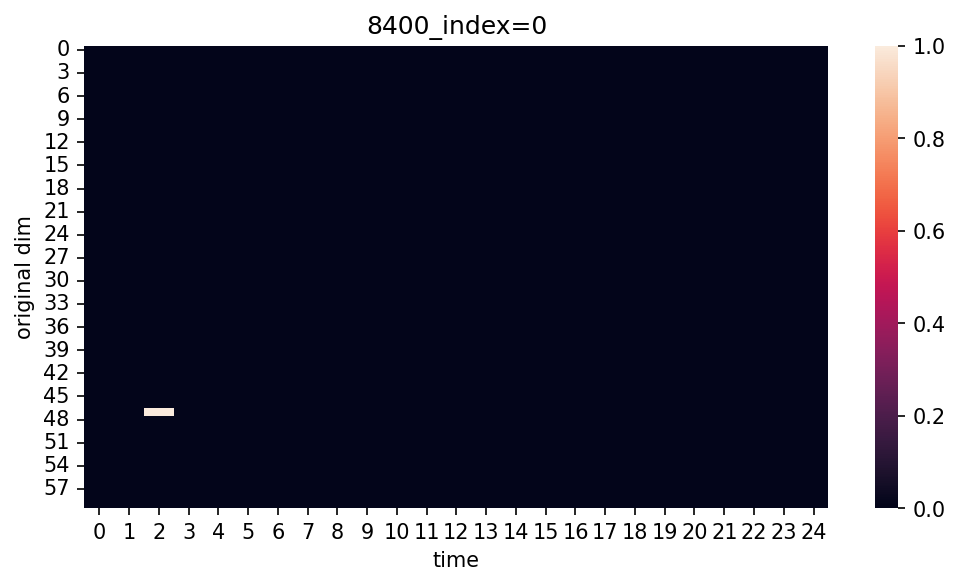

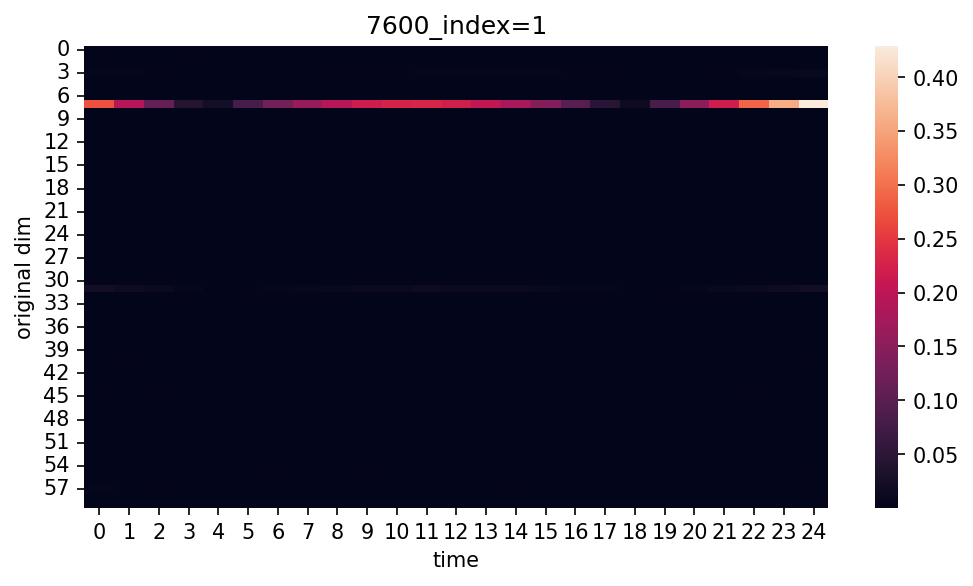

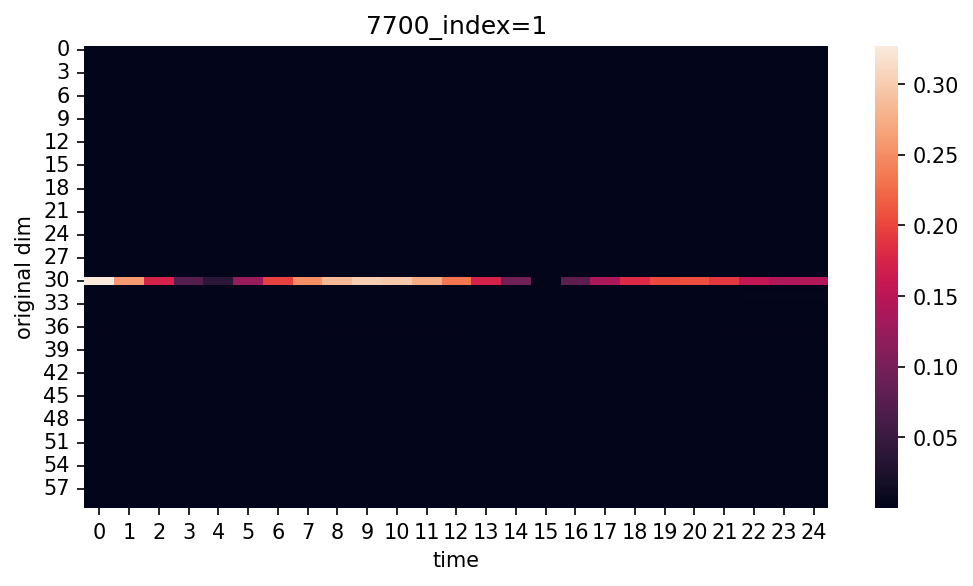

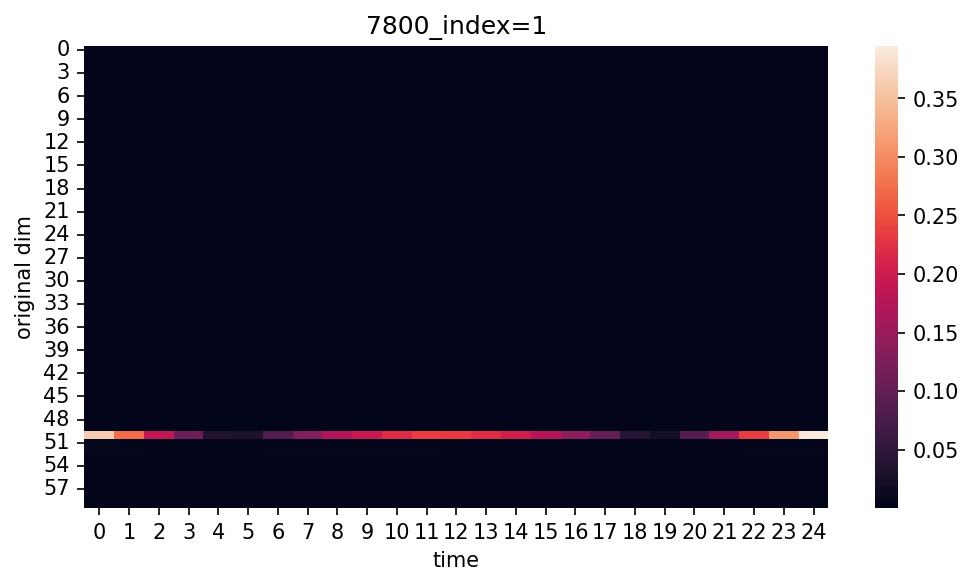

In [3]:
from svd_tool import analysis_u
analysis_u(us, seq_len=25, dims=60, start=start, end=end, interval=interval, target=[0,1,50])

  0%|          | 0/9 [00:00<?, ?it/s]

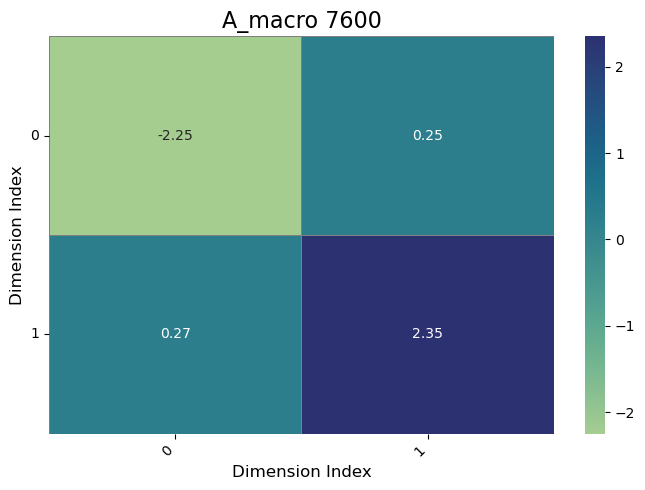

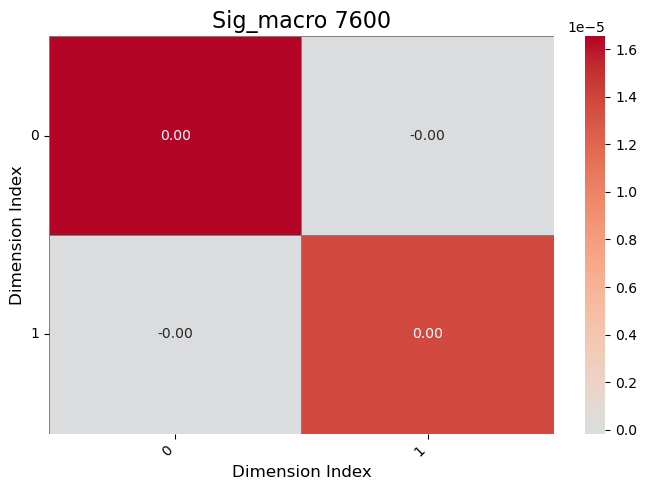

 11%|█         | 1/9 [00:00<00:03,  2.21it/s]

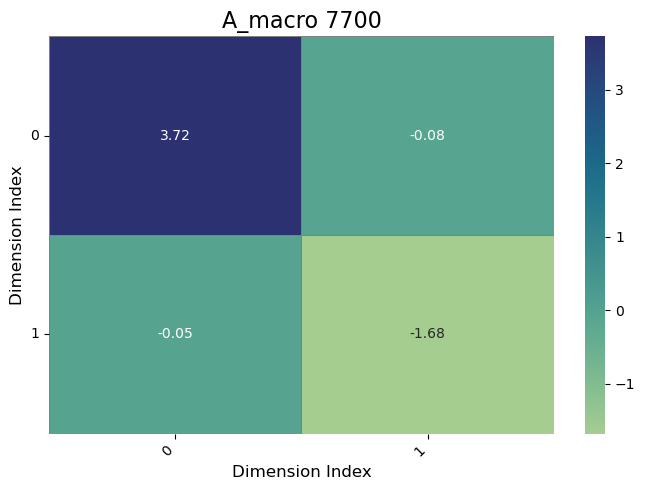

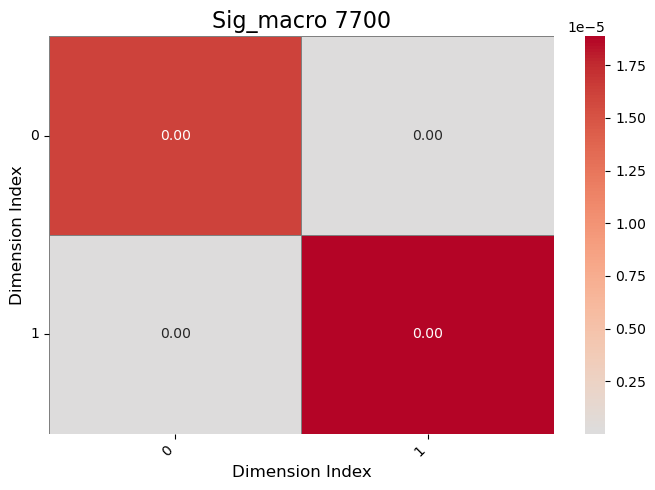

 22%|██▏       | 2/9 [00:00<00:02,  2.68it/s]

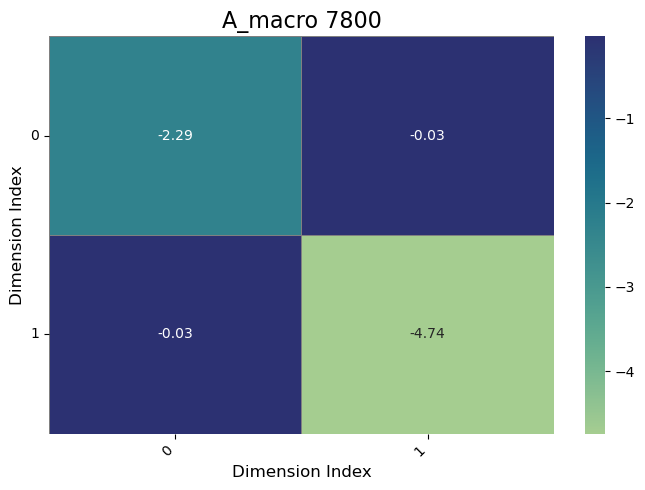

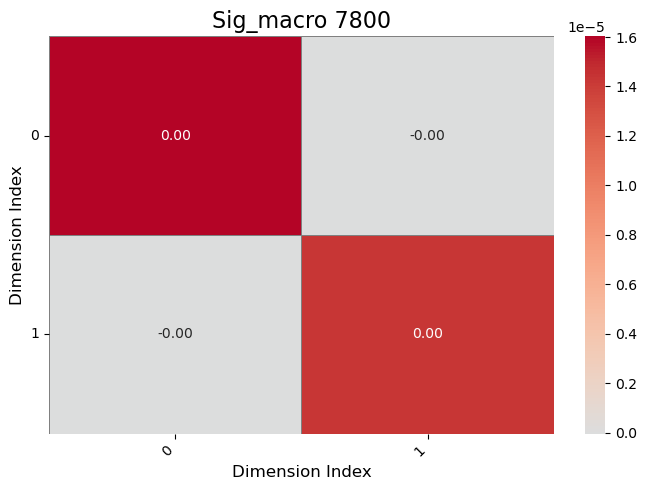

 33%|███▎      | 3/9 [00:01<00:02,  2.86it/s]

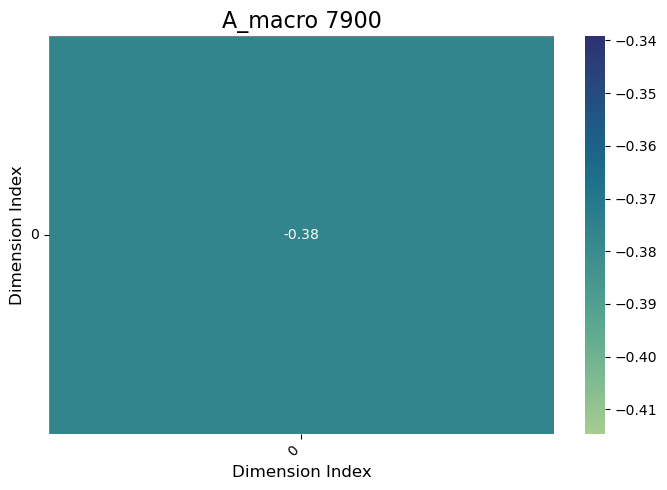

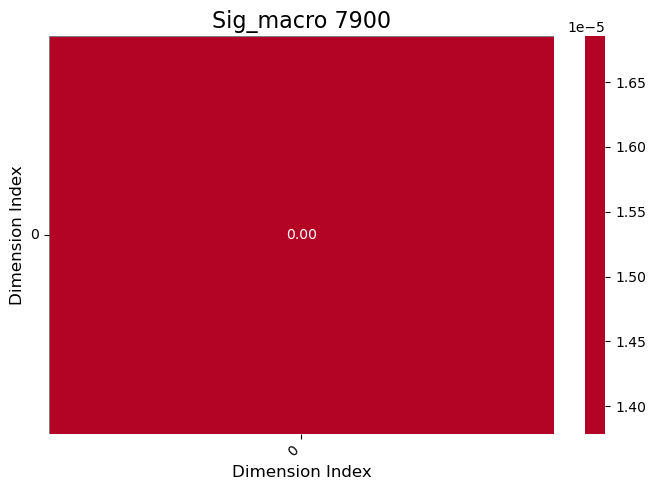

 44%|████▍     | 4/9 [00:01<00:01,  2.97it/s]

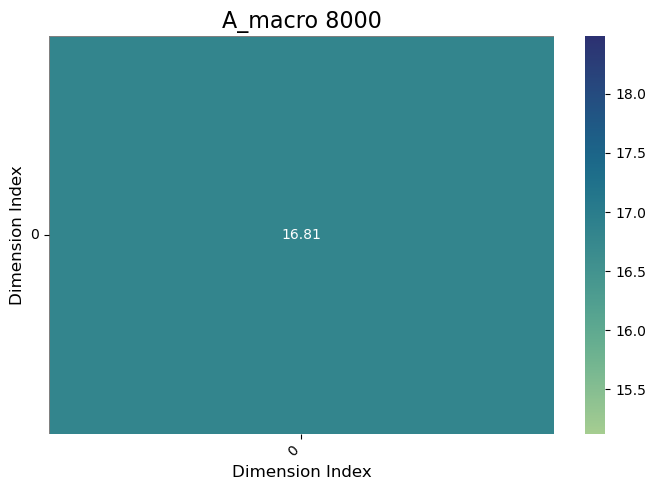

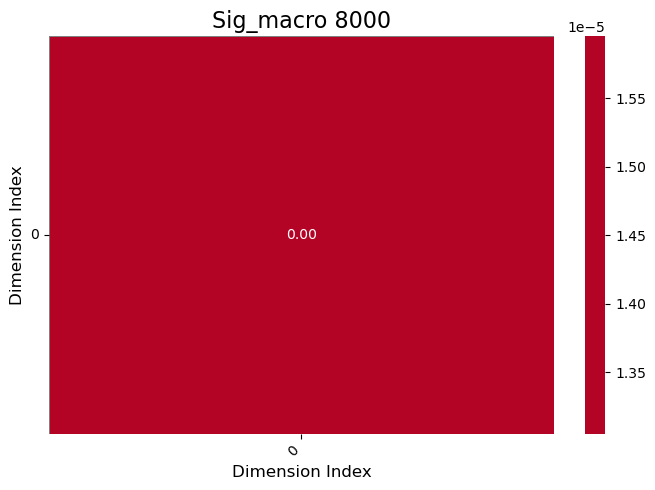

 56%|█████▌    | 5/9 [00:01<00:01,  3.08it/s]

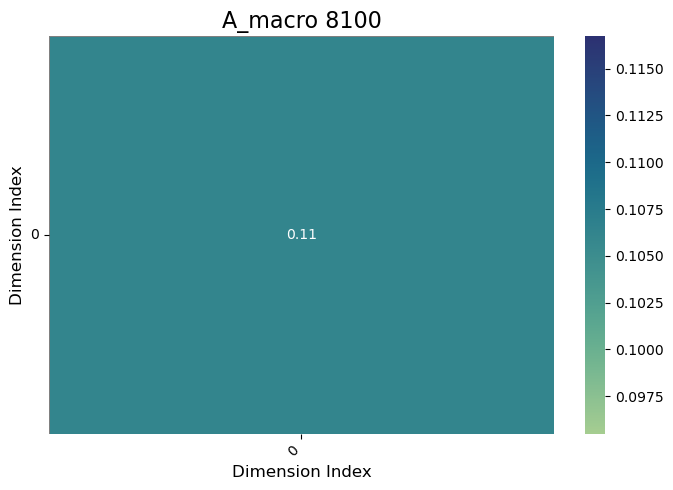

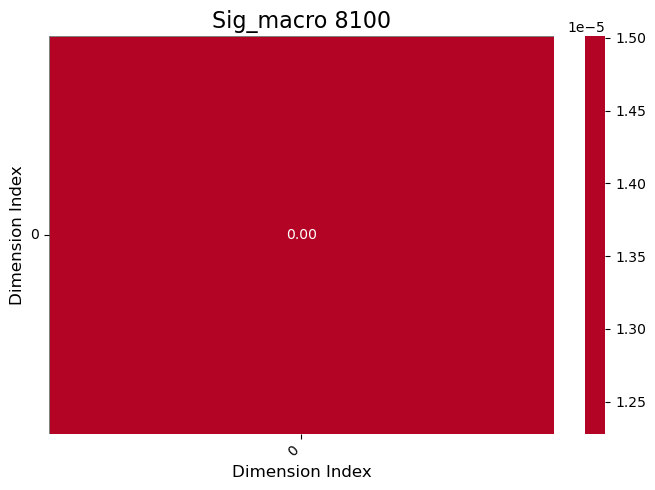

 67%|██████▋   | 6/9 [00:02<00:00,  3.11it/s]

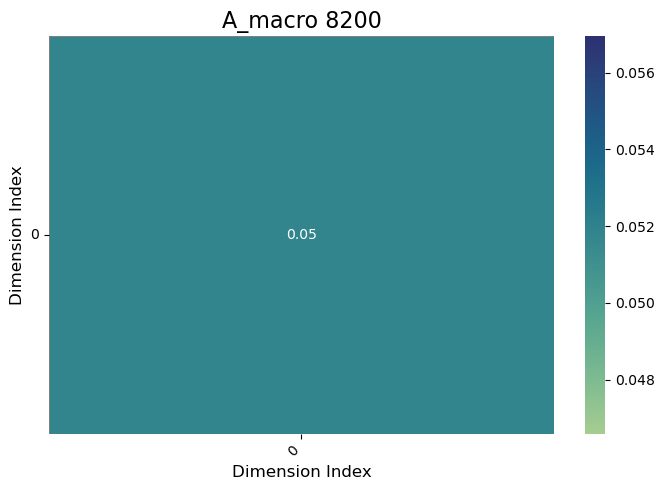

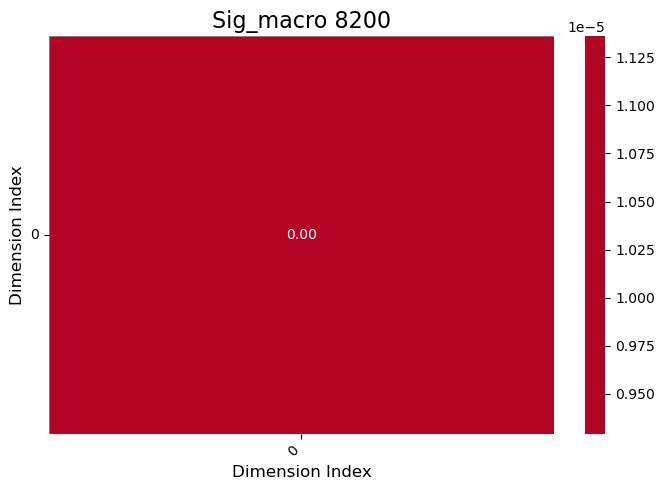

 78%|███████▊  | 7/9 [00:02<00:00,  2.91it/s]

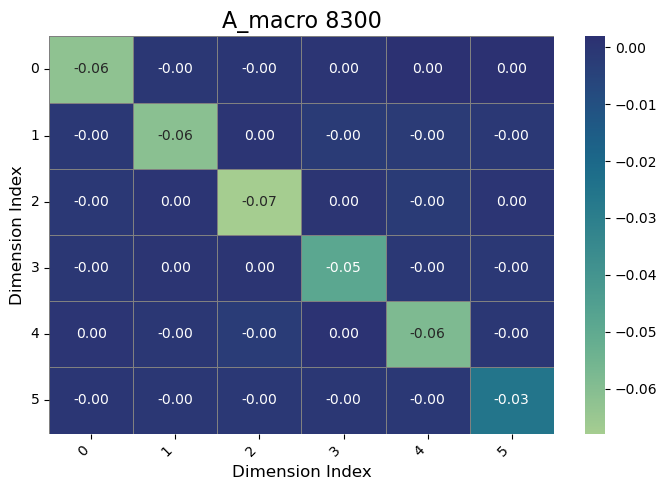

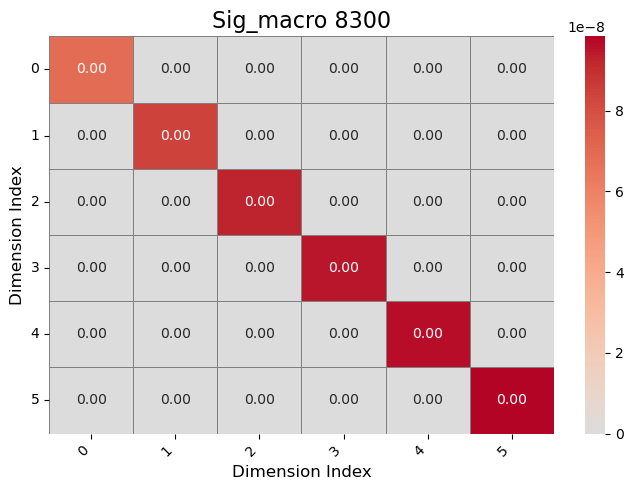

 89%|████████▉ | 8/9 [00:03<00:00,  2.34it/s]

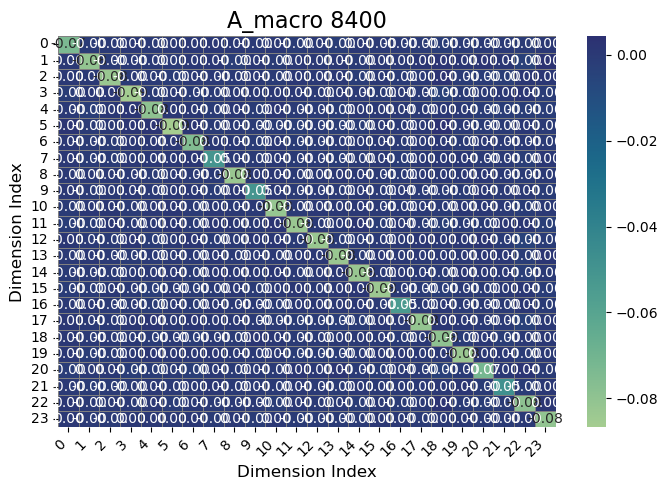

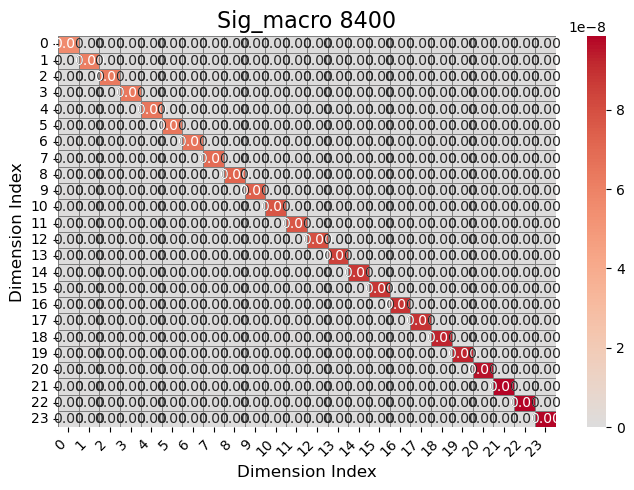

100%|██████████| 9/9 [00:06<00:00,  1.34it/s]


In [4]:
import numpy as np
from tqdm import tqdm
from scipy.linalg import sqrtm, inv
import matplotlib.pyplot as plt
from scipy.linalg import eig
from cycler import cycler
import pandas as pd
import math
import seaborn as sns



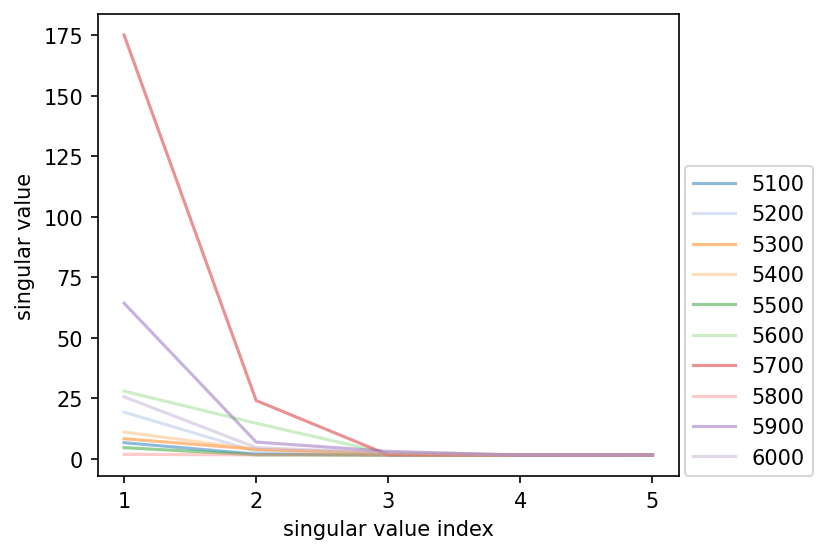

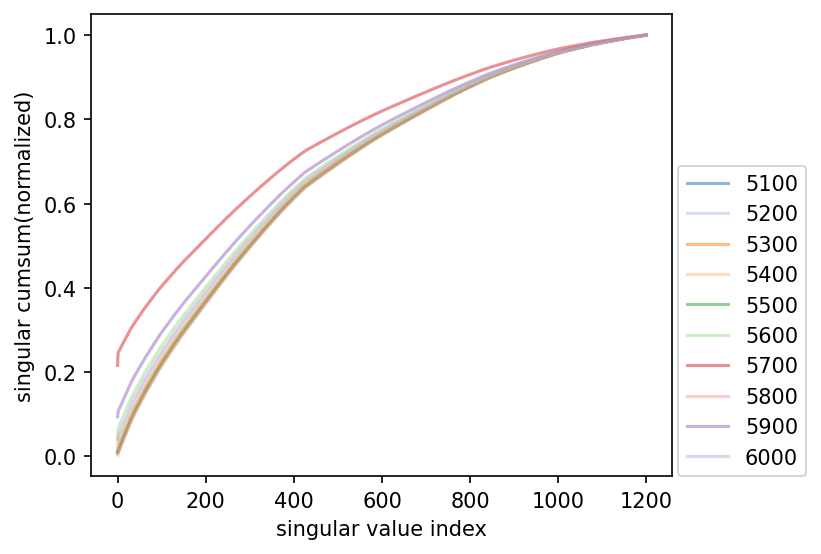

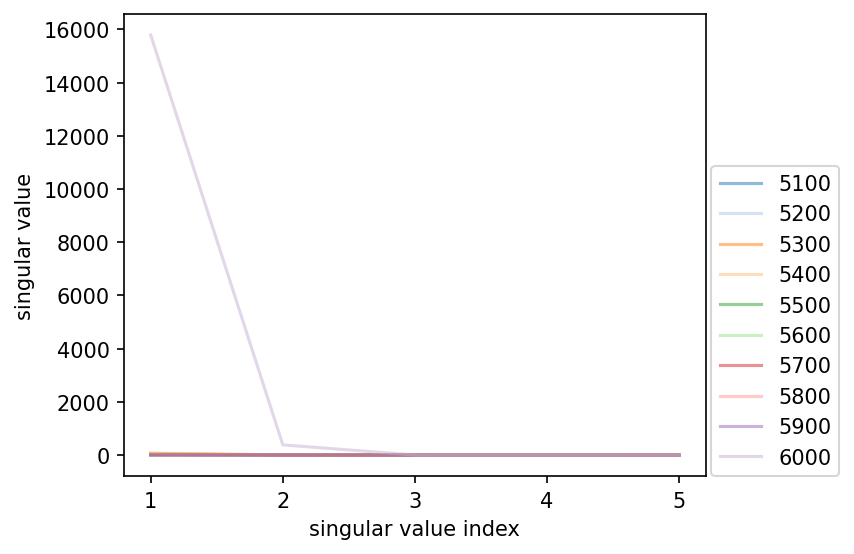

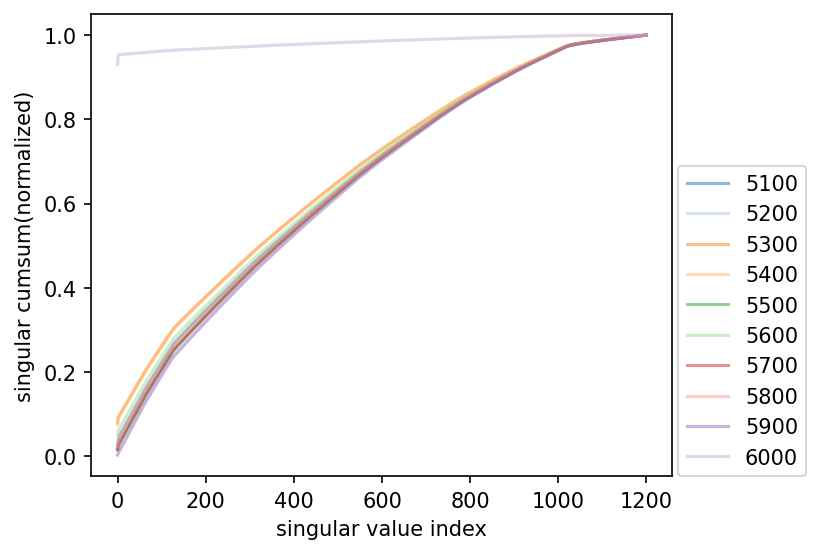

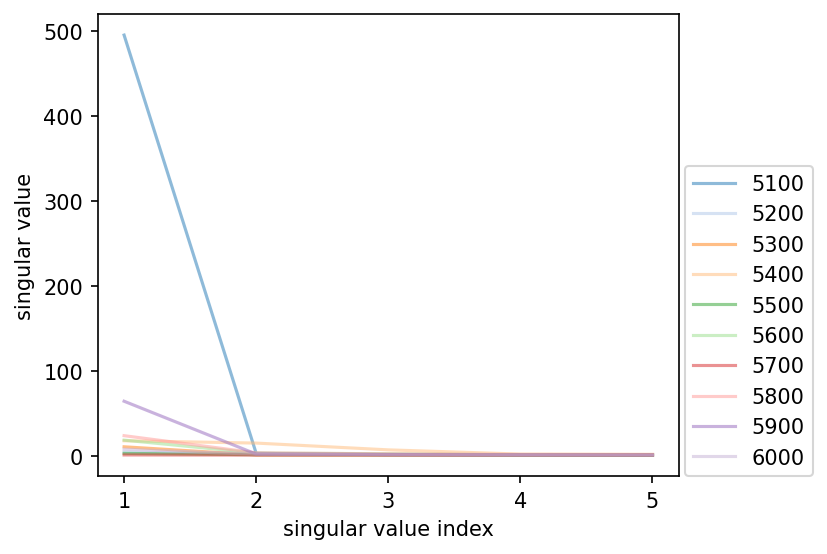

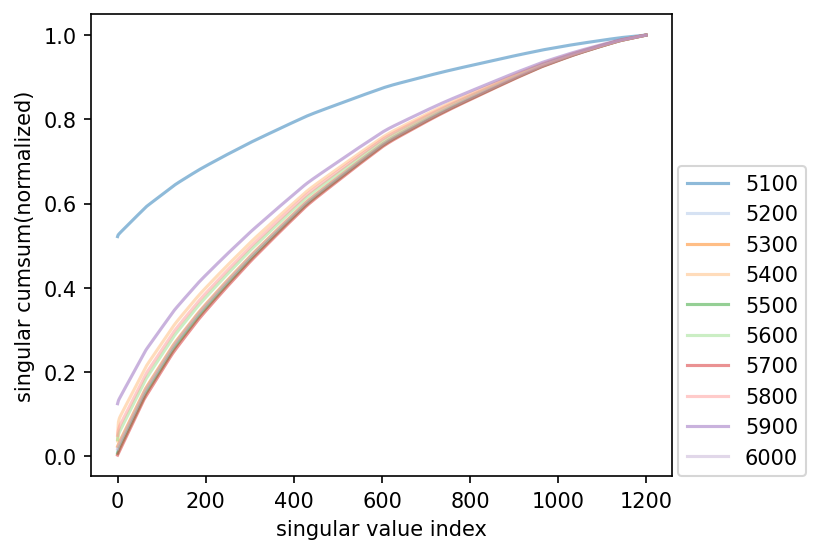

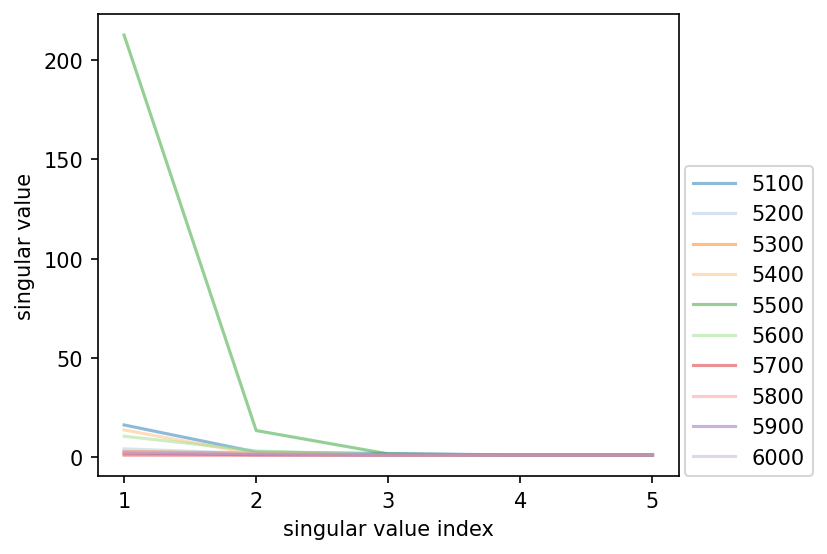

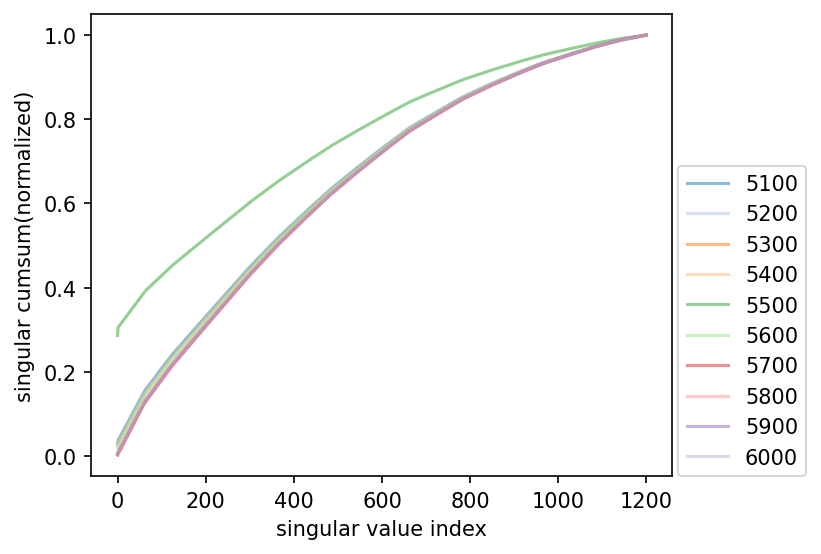

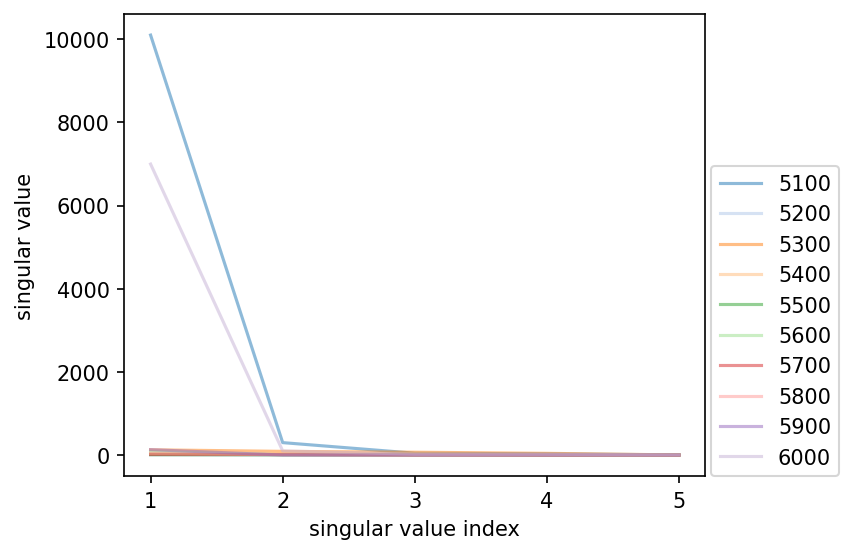

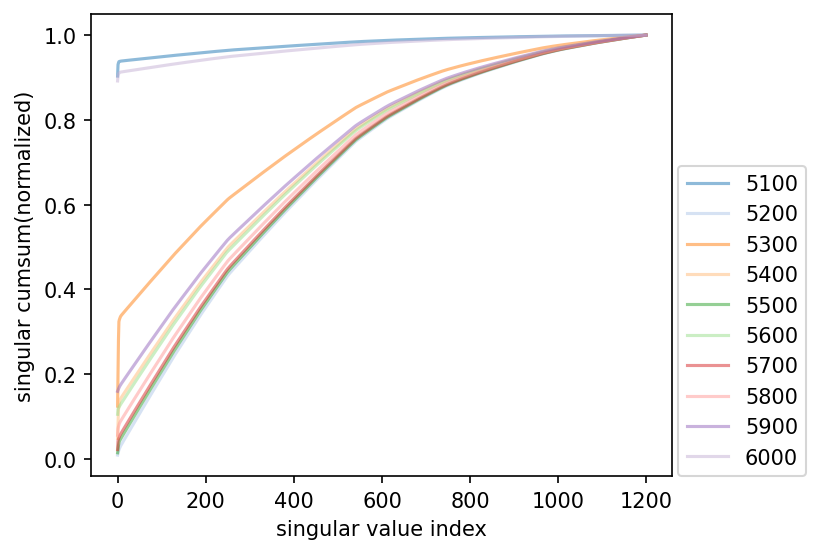

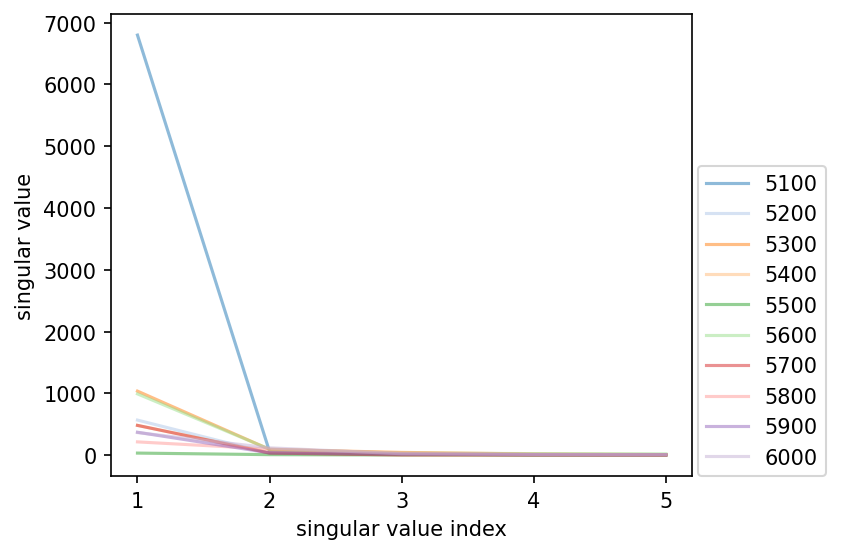

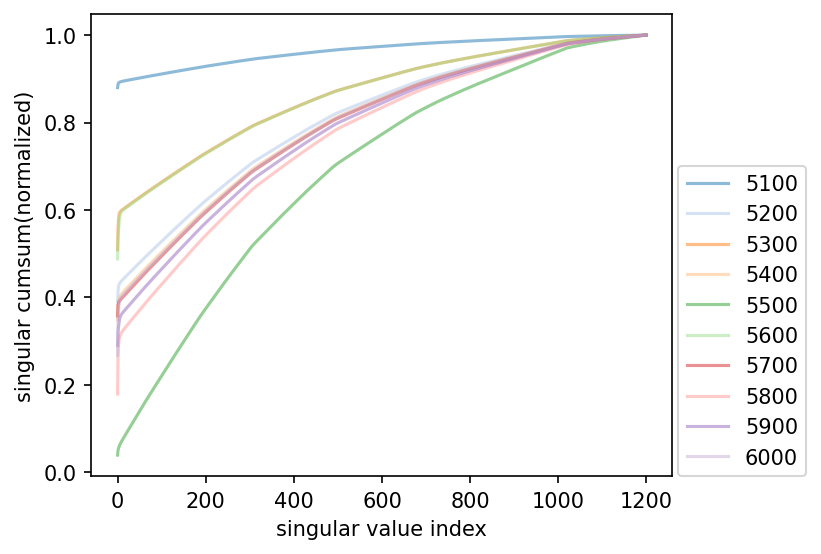

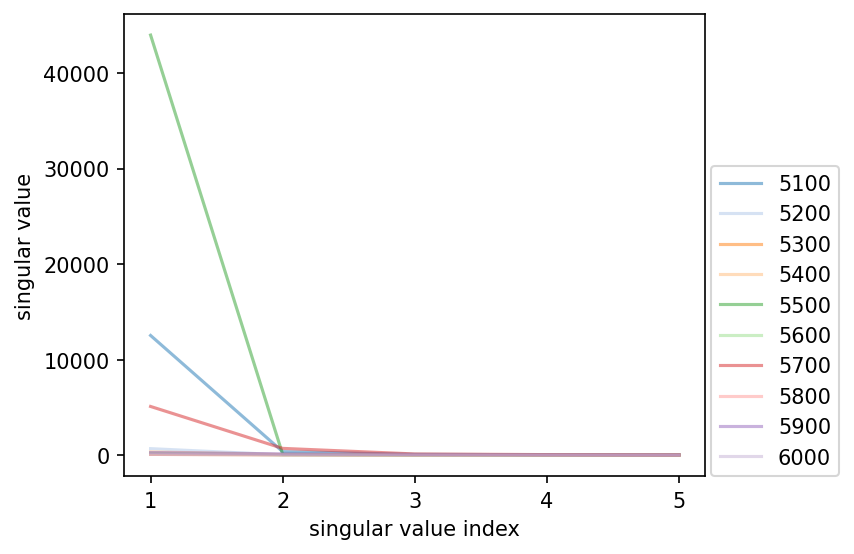

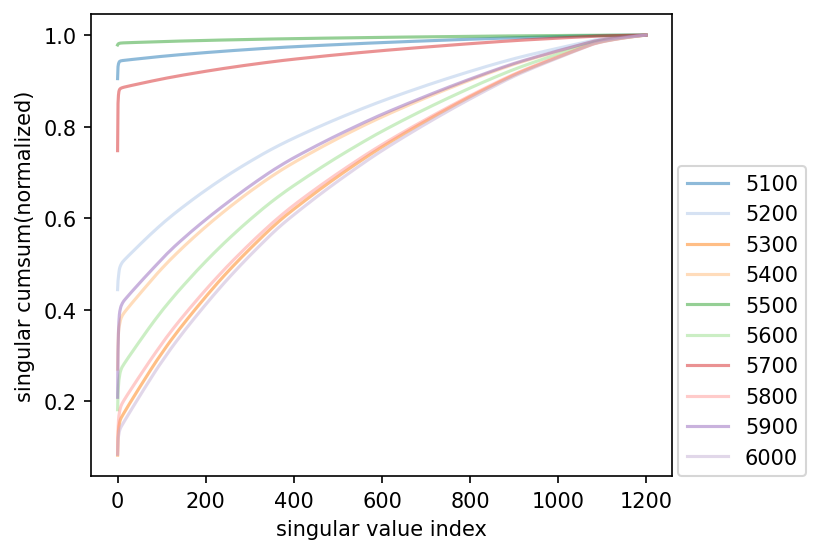

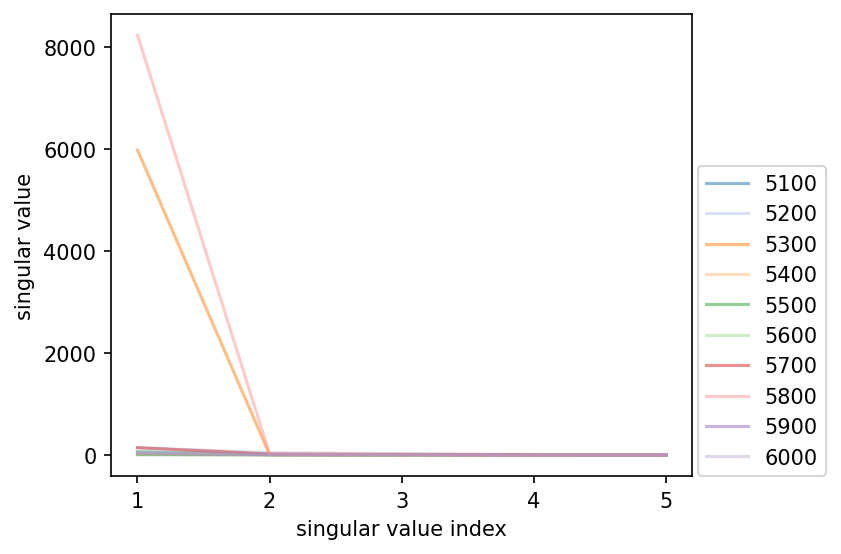

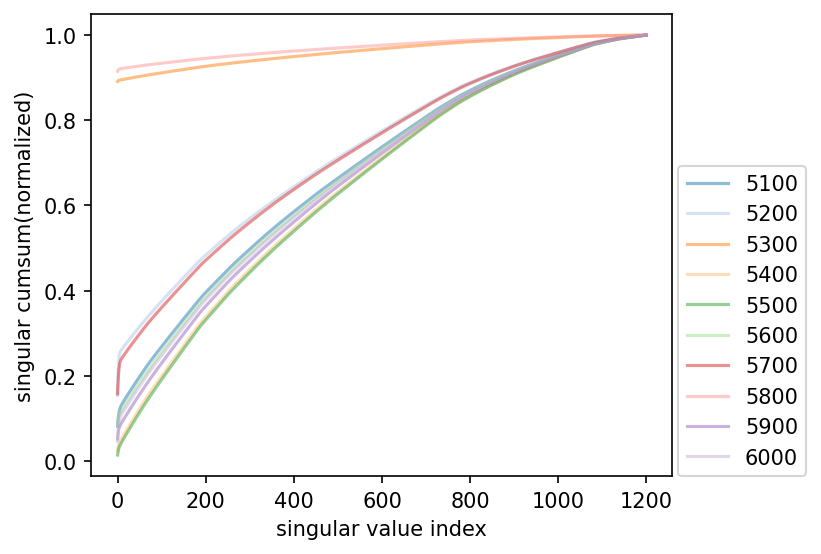

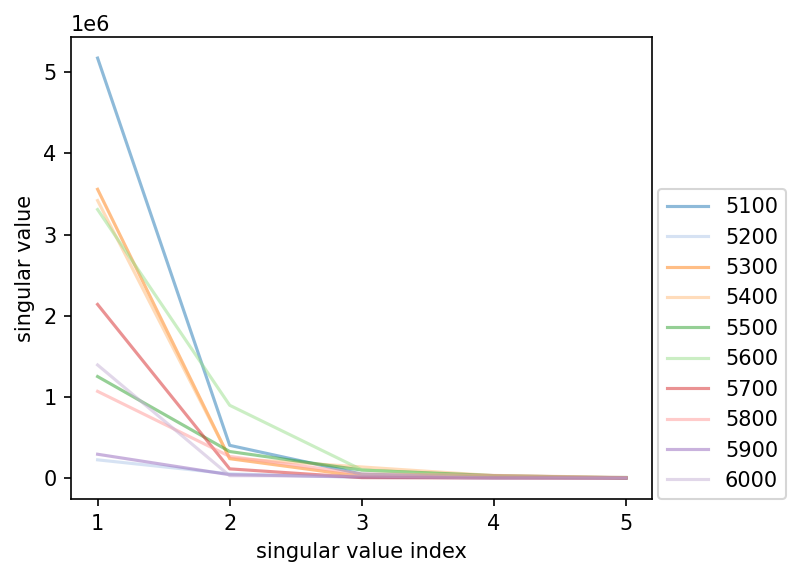

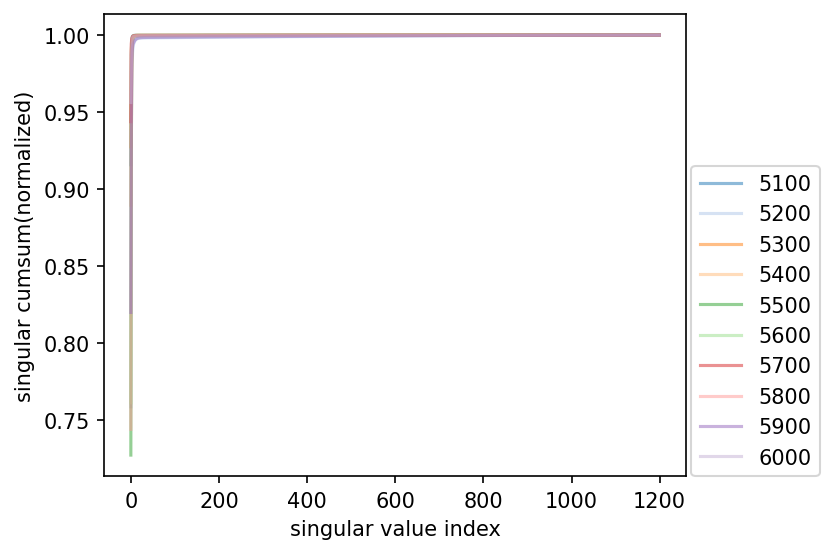

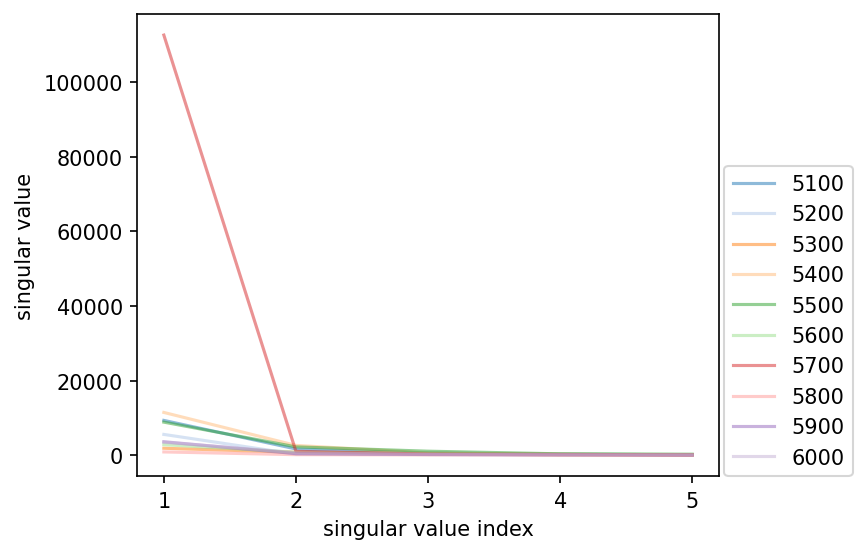

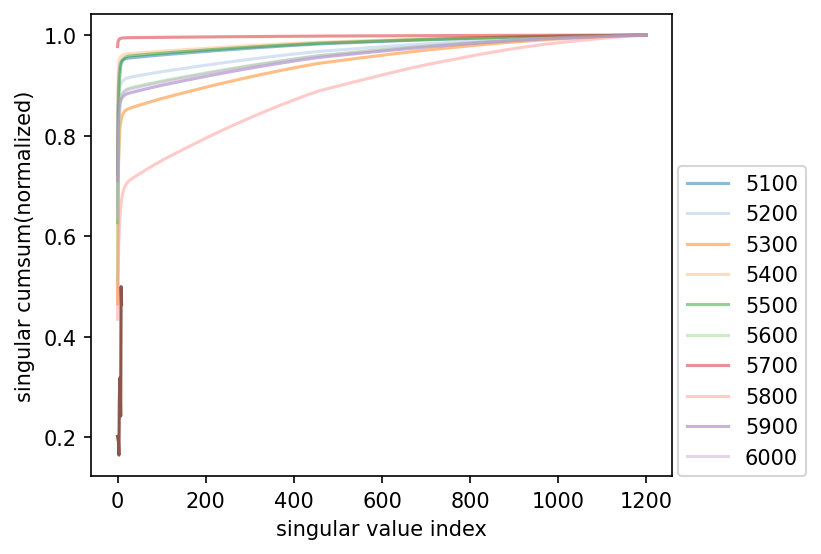

In [5]:
att_ls = [1,20,30,60,80,100,120,140,160,200]
gini_ls = []
for i in att_ls:
    test_id = 'long_term_forecast_swarm_2_{0}_30_10000_iTransformer_cov_Couzin_ft-1_sl20_pl20_dm512_nh8_el4_dl1_df512_fc3_flocnormal_lam0.001_dtTrue_Exp_'.format(i)
    gn_dic, singular, us, vts = plot_sin_cum_general(test_id, m='all', seed = 0, start=5100, end=6001, interval=100, sigmas=True, log_bool=False)
    mean_value = sum(gn_dic.values()) / len(gn_dic)
    gini_ls.append(mean_value)
plt.plot(gini_ls)